#### Import / Global Vars

In [83]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [84]:
#imports section
import pandas_datareader.data as web
import numpy as np
import pandas as pd
import cvxpy as cvx
import re, os
import matplotlib.pyplot as plt
from math import *
from datetime import datetime, date, time, timedelta
from time import sleep
from clean_mvo_utils import *
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [85]:
# Global variables
log = True
refresh_pricing = False
universe = 'spy-sectors' # 'spy_sectors OR 'ark_etfs'
active_etf = None # ETF name OR None for broad market
#variables for performance analysis
frequency = "W-THU" # initial value for lookback
lb = 60; min_gross=0.7; max_gross=1; min_w=0.0; max_w=0.05 # default optimization vars

#### Load sector components from hard-drive

In [86]:
# load spy sector components
# would be nice to load a JSON with configuration
ticker_map = {
    'benchmark': ['SPY'],
    'equity': ['VTI','VTV','VOE','VBR','VEA','VWO'],
    'fixed_income': ['VTIP', 'SHV', 'MUB', 'LQD', 'BNDX', 'EMB'],
    'spy-sectors': ['XLE', 'XLU', 'XLK', 'XLB', 'XLP', 'XLY', 'XLI', 'XLV', 'XLF', 'XLRE'],
    'ark-etfs': ['ARKG', 'ARKK', 'ARKQ', 'ARKW']
}

config = {
    'spy-sectors' : {
        'hold_cols': ['Symbol','Company Name', 'Index Weight'],
        'hold_format': r'holdings-spy-',
        'idx_col': 'Symbol',
        'fname': 'spy-sectors',
        'skiprows': 1
    },
    'ark-etfs' : {
        'hold_cols': ['ticker','company', 'weight(%)'],
        'hold_format': r'holdings-ark-',
        'idx_col': 'ticker',
        'fname': 'ark-etfs',
        'skiprows': 0
    }
}

hold_cols = config[universe]['hold_cols']
hold_format = config[universe]['hold_format']
idx_col = config[universe]['idx_col']
fname = config[universe]['fname']
skiprows = config[universe]['skiprows']

companies = load_components(
    companies, hold_format, hold_cols, 
    idx_col, ticker_map[universe], srows=skiprows)
print("Companies loaded:", companies.shape)
px_etfs = load_pricing(fname + '.csv', 'Date')
px_spy = load_pricing('SPY.csv', 'Date')

Companies loaded: (505, 3)
Loaded pricing for spy-sectors.csv, with shape (69, 10)
Loaded pricing for SPY.csv, with shape (69, 1)


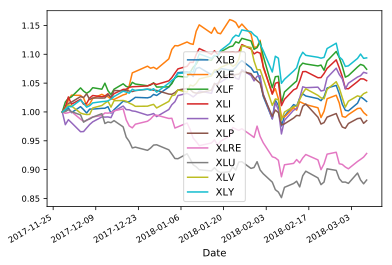

In [87]:
compound(px_etfs).plot(fontsize='small') # exclude from long strat the negative sectors?

#### Get Data from the Server

In [88]:
# New approach using dynamic key lookup name
if refresh_pricing:
    etfs = [e for e in ticker_map[universe]]
    refresh_components(etfs)
    get_safe_pricing(universe + '.csv', ticker_map[universe], start_date)
    get_safe_pricing('SPY.csv', ['SPY'], start_date)
    px_etfs = load_pricing(universe + '.csv', 'Date')
    px_spy = load_pricing('SPY.csv', 'Date')

In [89]:
# Load pricing for components of each sectors
consol_px = clean_nas(load_consol_px(ticker_map, universe))
if(active_etf != None): companies = companies[companies['ETF']==active_etf] # filter by selected ETF
tickers = companies.index.tolist()
tickers=[i for i in tickers if i not in ['BF.b','BRK.b']] ## esta es una correcion extra para no incluir 'BF.b','BRK.b'
consol_px = consol_px[list(set(tickers))]

Loaded pricing for XLE-hold-pricing.csv, with shape (69, 32)
Loaded pricing for XLU-hold-pricing.csv, with shape (69, 28)
Loaded pricing for XLK-hold-pricing.csv, with shape (69, 71)
Loaded pricing for XLB-hold-pricing.csv, with shape (69, 25)
Loaded pricing for XLP-hold-pricing.csv, with shape (69, 34)
Loaded pricing for XLY-hold-pricing.csv, with shape (69, 84)
Loaded pricing for XLI-hold-pricing.csv, with shape (69, 70)
Loaded pricing for XLV-hold-pricing.csv, with shape (69, 61)
Loaded pricing for XLF-hold-pricing.csv, with shape (69, 67)
Loaded pricing for XLRE-hold-pricing.csv, with shape (69, 33)


#### Generate Trading Recomendations

In [90]:
# Removing tickers for M&A targets and diff class shares of same co.
remove_tickers = ['CSRA', 'DPS', 'UAA', 'DISCK', 'JUNO', 'XL', 'WELL', 'BKNG', 'SNI'] # example: two M&A targets, diff share classes...
remove = list(set(remove_tickers).intersection(consol_px.columns.tolist()))
if len(remove) > 0:
    consol_px.drop(remove, axis=1, inplace=True)

In [91]:
# range of potential gammas using logspace
as_of = consol_px.index.to_datetime()[-1:] # date as of when we want the weights vector
SAMPLES = 100; gamma_vals = np.logspace(-2, 3, num=SAMPLES)
gamma_val, gamma_sr = quick_gamma(
    gamma_vals, consol_px, hist_window, lb, 
    as_of, min_gross, max_gross, min_w, max_w)
gamma_val, gamma_sr

(43.28761281083057, 3.3329757430930638)

In [92]:
print("Gamma: {0:.2f}, Lookback: {1}, Max Weight: {2}".format(gamma_val, lb, max_w))

Gamma: 43.29, Lookback: 60, Max Weight: 0.05


In [93]:
# run optimization with best gamma, returns initial weights
px_portion, returns, alloc, pdf = recommend_allocs(
    consol_px, hist_window, lb, frequency, min_gross, max_gross, min_w, max_w, gamma_val)
rec = last_allocation(alloc, 0.01)
tickers = rec.index.tolist()
recommend = rec.copy()
cos_no_dup = companies.drop_duplicates(subset='Company')
recommend['Sector'] = cos_no_dup.loc[tickers]['ETF']
recommend['Company'] = cos_no_dup.loc[tickers][['Company']]
recommend = recommend.astype({"Allocation": np.float})
recommend[['Company', 'Sector', 'Allocation']]
recommend

,Allocation,Sector,Company
QRVO,0.016208,XLK,"Qorvo, Inc"
COTY,0.041071,XLP,Coty Inc.
GWW,0.020790,XLI,Grainger W.W. Inc
RE,0.036445,XLF,Everest Re Group Ltd
AMZN,0.050000,XLY,Amazon.com Inc
EA,0.021770,XLK,Electronic Arts
TPR,0.020956,XLY,"Tapestry, Inc"
EL,0.050000,XLP,Estee Lauder Cos. A
RHT,0.011076,XLK,Red Hat Inc
EVHC,0.050000,XLV,Envision Healthcare Corp


In [94]:
# plots all tickers to verify if there are any M&A targets
if refresh_pricing:
    for t in recommend.sort_index().index:
        fig, ax = plt.subplots()
        plt.title(cos_no_dup.loc[t]['Company'])
        df_range = consol_px[t][-lb:]
        #dates = df_range.index.to_datetime()
        #values = df_range.values.tolist()
        #plt.plot(dates, values)
        #plt.xticks(np.arange(0, len(dates)), dates, rotation=45)
        fig.tight_layout()
        df_range.plot(fontsize='small')
        plt.show()

In [95]:
sect_group_stats(recommend, 'Sector').sort_values(by='Sector Weight', ascending=False)

Total % Allocation 68.97


,Sector Weight,Avg Position
XLY,0.190003,0.038001
XLK,0.179887,0.029981
XLP,0.131884,0.043961
XLV,0.080686,0.040343
XLB,0.050000,0.050000
XLF,0.036445,0.036445
XLI,0.020790,0.020790


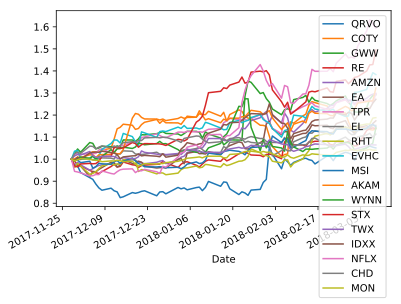

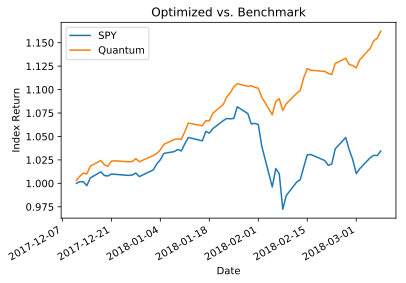

In [98]:
compound(consol_px[recommend.index][-hist_window:]).plot()
plot_two_series(compound(px_spy.loc[pdf.index]), pdf, 'SPY', 'Quantum', 'Date', 'Index Return', 'Optimized vs. Benchmark')

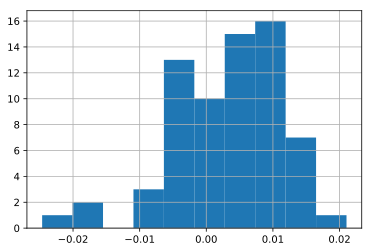

In [108]:
hdf = consol_px[tickers].pct_change().mean(axis=1)
hdf.hist()

In [97]:
# Outputs for trade execution
px = consol_px[recommend.index][-lb:]
date = px[-1:].index.to_datetime().strftime(date_fmt)[0]
ret, risk = port_metrics(px_portion, rec)

trading_cols = ['Company', 'Price', 'Allocation', 'Dollar Value', 'Shares']
trading_df = pd.DataFrame([], index=rec.index, columns=trading_cols)

round_shares = lambda x: round(x, 0)
port_bal = 231000; alloc = rec.T.values
pvalue = (port_bal * alloc)
shares = (port_bal * alloc) / px[-1:]
shares.apply(round_shares).T.sort_index()

trading_df['Company'] = recommend['Company']
trading_df['Price'] = px[-1:].T
trading_df['Allocation'] = recommend['Allocation']
trading_df['Dollar Value'] = trading_df['Allocation'] * port_bal
trading_df['Shares'] = trading_df['Dollar Value'] / trading_df['Price']

print("Time Window: {}, Lookback: {}, MinGross: {}, MaxGross: {}, MinWeight: {}, MaxWeight: {}".format(hist_window, lb, min_gross, max_gross, min_w, max_w))
print("Ann. Ret: {0:.2f}, Risk: {1:.2f} Sharpe: {2:.2f}".format(ret, risk, ret / risk))
print("Date: {0}, Total Invested: {1:.2f}, Total Allocation: {2:.2f}%".format(date, trading_df['Dollar Value'].sum(), trading_df['Allocation'].sum() * 100))
trading_df.head()
trading_df = trading_df.astype({'Dollar Value':np.int, 'Shares':np.int})
trading_df.sort_index()

Time Window: 100, Lookback: 60, MinGross: 0.7, MaxGross: 1, MinWeight: 0.0, MaxWeight: 0.05
Ann. Ret: 0.15, Risk: 0.05 Sharpe: 3.33
Date: 2018-03-08, Total Invested: 159319.62, Total Allocation: 68.97%


,Company,Price,Allocation,Dollar Value,Shares
AKAM,Akamai Technologies Inc,73.199997,0.030832,7122,97
AMZN,Amazon.com Inc,1549.349976,0.050000,11549,7
CHD,Church & Dwight Co,50.615002,0.040813,9427,186
COTY,Coty Inc.,19.330000,0.041071,9487,490
EA,Electronic Arts,128.500000,0.021770,5028,39
EL,Estee Lauder Cos. A,143.639999,0.050000,11549,80
EVHC,Envision Healthcare Corp,42.500000,0.050000,11549,271
GWW,Grainger W.W. Inc,272.000000,0.020790,4802,17
IDXX,IDEXX Laboratories Inc,197.130005,0.030686,7088,35
MON,Monsanto Co.,122.919998,0.050000,11549,93
